# Neural Code Final Portfolio - Component 2

This notebook gives a more detailed exposition of the analyses performed in Courellis et al. (2024).

## Preliminaries

In [101]:
# Required packages
import os
import json
import time
import numpy as np
import pandas as pd
from scipy.io import loadmat
import itertools

from scipy.stats import binom

from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

import helper_functions as F

# Paths to files
FOLDER_PATH = "2024courellis/"
neu_mat_path = os.path.join(FOLDER_PATH, "data/neu.mat")

## Load and inspect datasets

### Session-level behavior

In [61]:
with open("beh.json", "r") as f:
    all_beh_data = json.load(f)["beh"]

# Load behavioral data organized by session
beh_data = pd.DataFrame(all_beh_data["data"])
beh_data

,sessionID,events
0,P61CS_1,"[[1551091404901085.0, 55], [1551091406087648.0..."
1,P62CS_1,"[[1555760333243868.0, 55], [1555760334376711.0..."
2,P62CS_2,"[[1555761804593152.0, 55], [1555761805744683.0..."
3,P62CS_3,"[[1556200582588169.0, 55], [1556200583950356.0..."
4,P62CS_4,"[[1556641173506903.0, 55], [1556641174833121.0..."
5,P63CS_1,"[[1566756422494843.0, 55], [1566756423712092.0..."
6,P63CS_2,"[[1566816971749967.0, 55], [1566816972930498.0..."
7,P63CS_3,"[[1566836657844104.0, 55], [1566836659043604.0..."
8,P65CS_1,"[[1580644232055429.0, 55], [1580644233132866.0..."
9,P65CS_2,"[[1580645831803162.0, 55], [1580645832879380.0..."


In [62]:
# Task information for given session
task_data = pd.DataFrame(all_beh_data["task_info"])
task_data

,context,stim_sequence,reward_sequence,response_sequence,is_novel_variant,novel_stim_dir,novel_block_image,remapping,stim_to_replace,replace_name
0,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 4, 1, 2, 4, 4, 4, 3, 1, 4, 4, 3, 4, 3, 2, ...","[25, 5, 5, 25, 5, 5, 5, 25, 5, 5, 5, 25, 5, 25...","[0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, ...",NaN,NaN,NaN,NaN,NaN,NaN
1,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 2, 4, 4, 3, 2, 3, 1, 4, 4, 4, 2, 3, 1, 2, ...","[5, 25, 5, 5, 25, 25, 25, 5, 5, 5, 5, 25, 25, ...","[1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, ...",NaN,NaN,NaN,NaN,NaN,NaN
2,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 3, 3, 4, 2, 2, 2, 4, 4, 1, 1, 2, 1, 3, 2, ...","[5, 25, 25, 5, 25, 25, 25, 5, 5, 5, 5, 25, 5, ...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, ...",NaN,NaN,NaN,NaN,NaN,NaN
3,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 3, 3, 1, 2, 2, 3, 2, 4, 4, 2, 2, 3, 4, ...","[25, 25, 25, 25, 5, 25, 25, 25, 25, 5, 5, 25, ...","[0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...",NaN,NaN,NaN,NaN,NaN,NaN
4,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, ...","[2, 1, 2, 3, 2, 2, 4, 3, 3, 4, 2, 4, 4, 2, 3, ...","[25, 5, 25, 25, 25, 25, 5, 25, 25, 5, 25, 5, 5...","[0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,NaN,NaN,NaN,NaN
5,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 2, 3, 3, 4, 2, 3, 3, 1, 1, 2, 4, 2, 3, 1, ...","[5, 25, 25, 25, 5, 25, 25, 25, 5, 5, 25, 5, 25...","[1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, ...",NaN,NaN,NaN,NaN,NaN,NaN
6,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, ...","[1, 3, 2, 4, 4, 3, 2, 3, 1, 4, 4, 4, 2, 3, 1, ...","[5, 25, 25, 5, 5, 25, 25, 25, 5, 5, 5, 5, 25, ...","[1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, ...",NaN,NaN,NaN,NaN,NaN,NaN
7,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, ...","[2, 4, 2, 1, 2, 3, 2, 2, 4, 3, 3, 4, 2, 4, 4, ...","[25, 5, 25, 5, 25, 25, 25, 25, 5, 25, 25, 5, 2...","[0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, ...",NaN,NaN,NaN,NaN,NaN,NaN
8,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 2, 3, 3, 4, 2, 3, 3, 1, 1, 2, 4, 2, 3, 1, ...","[5, 25, 25, 25, 5, 25, 25, 25, 5, 5, 25, 5, 25...","[1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, ...",NaN,NaN,NaN,NaN,NaN,NaN
9,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, ...","[1, 3, 2, 4, 4, 3, 2, 3, 1, 4, 4, 4, 2, 3, 1, ...","[5, 25, 25, 5, 5, 25, 25, 25, 5, 5, 5, 5, 25, ...","[1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, ...",NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
type(task_data["context"].iloc[0])

list

In [64]:
def get_block_num(context : list[int]) -> np.array:
    """
    Define blocks of trials where contexts are alternated by finding where the
    difference between adjacent context values is non-zero.

    Parameters
    ----------
    context : list[int]
        Latent contexts (1 or 2) for each stimulus in the trial.     
    
    Returns
    -------
    np.array
        Array of block numbers for each stimulus.
    """
    transitions = np.where(np.abs(np.diff(context)) > 0)[0] + 1
    block_idx = np.array([[0, *transitions], [*transitions, len(context)]])
    block_nums = np.full(len(context), np.nan)
    for i in range(block_idx.shape[1]):
        block_nums[block_idx[0, i] : block_idx[1, i]] = i 
    return block_nums

def get_instance_num(stim : np.array, block : np.array) -> np.array:
    """
    Get the instance number for the image in each trial block.

    Parameters
    ----------
    stim : np.array
        Stimulus identities for each trial.
    block : np.array
        Array of block numbers for each stimulus.

    Returns
    -------
    np.array
        Array of instance numbers for each stimulus image. 
    """
    instance_nums = np.full(len(stim), np.nan)
    for block_num in np.unique(block):
        instance_dict = {}
        block_idx = np.where(block == block_num)[0]
        for idx in block_idx:
            if stim[idx] not in instance_dict:
                # Reset count for new stimulus
                instance_dict[stim[idx]] = 1
            else:
                instance_dict[stim[idx]] += 1
            instance_nums[idx] = instance_dict[stim[idx]]
    return instance_nums

def get_session_accuracy(
    beh_data : pd.DataFrame,
    task_data : pd.DataFrame
) -> list[np.array]:
    """
    Method for computing session-level accuracy on inference trials (trials in 
    which given stimulus is encountered for the first time after a context 
    switch).

    Parameters
    ----------
    beh_data : pd.DataFrame
        Behavioral data for all sessions.
    task_data : pd.DataFrame
        Task information for each session.

    Returns
    -------
    list[np.array]
        Returns list of arrays of binary values to represent correct vs. 
        incorrect answer. Each array has 5 rows (last trial from previous block
        + 4 stimuli types) and [# blocks - 1] columns (since the first block is
        excluded).
    """
    prop_correct = []
    for i in range(len(task_data)):
        # Get block number
        context = task_data["context"].iloc[i]
        block_nums = get_block_num(context)
        gt = task_data["response_sequence"].iloc[i]
        stim_seq = task_data["stim_sequence"].iloc[i]

        # Find correct answers
        events_code = np.array(beh_data["events"].iloc[i])[:, 1]
        response = np.where(np.isin(events_code, [31, 36]), events_code, np.nan)
        response[response == 36] = 0
        response[response == 31] = 1
        response = response[~np.isnan(response)]
        is_correct = (response == gt)

        # Get instance number for image in each block
        instance_nums = get_instance_num(np.array(stim_seq), block_nums)
        is_correct_first = is_correct[instance_nums == 1]
        first_instance_idx = np.where(instance_nums == 1)[0]
        block_first_instance = block_nums[first_instance_idx]

        # Get accuracy of all first instances; pad with NaN if lengths mismatched
        idx = [
            np.where(block_first_instance == block)[0]
            for block in np.unique(block_first_instance)
        ]
        temp = [is_correct_first[i] for i in idx]
        max_len = max(len(instances) for instances in temp)
        temp = [
            np.pad(instances, (0, max_len - len(instances)), constant_values=np.nan)
            for instances in temp
        ]
        is_correct_first = np.concatenate(temp)

        # Reshape to stack accuracy across blocks
        is_correct_first = is_correct_first.reshape(
            len(np.unique(stim_seq)), int(np.max(block_nums).T) + 1
        )
        
        # Append last trial from previous block for each stimulus
        last_trials_idx = [
            np.where(block_nums == block)[0][-1]
            for block in np.unique(block_nums)
        ]
        is_correct_last = is_correct[last_trials_idx]

        # Exclude first block
        prop_correct.append(np.vstack([is_correct_last, is_correct_first])[:, 1:])
    return prop_correct

prop_correct = get_session_accuracy(beh_data, task_data)
prop_correct

[array([[ True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True, False, False,  True,  True,  True,  True, False],
        [False, False,  True,  True,  True, False,  True,  True,  True],
        [ True,  True, False, False,  True,  True,  True, False,  True],
        [ True, False,  True,  True,  True, False,  True,  True,  True]]),
 array([[False,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True, False, False, False, False, False,  True, False, False,
         False],
        [ True, False,  True, False, False,  True,  True,  True, False,
          True],
        [ True, False,  True,  True,  True, False,  True,  True,  True,
         False],
        [ True,  True, False,  True,  True,  True, False,  True,  True,
          True]]),
 array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True,  True,  True, Fals

In [65]:
def test_inference_trials(
    beh_data : pd.DataFrame,
    task_data : pd.DataFrame
) -> dict:
    """
    Parameters
    ----------
    beh_data : pd.DataFrame
    task_data : pd.DataFrame

    Returns
    -------
    dict
        Dictionary with statistical significance for baseline/inference trials
        and proportion of correct responses on inference trials.
    """
    # Get session-level accuracy for each trial
    prop_correct = get_session_accuracy(beh_data, task_data)

    baseline = np.full(len(prop_correct), np.nan)
    inference = np.full(len(prop_correct), np.nan)
    inf_perf = np.full(len(prop_correct), np.nan)

    for i, X in enumerate(prop_correct):
        # First inference trial in third column
        inf_trials = X[:, 2]
        valid_trials = np.sum(~np.isnan(inf_trials))

        # Check significance of behavior against chance (0.5)
        baseline[i] = 1 - binom.cdf(np.sum(X[:, 0]), len(X[:, 0]), 0.5)
        inference[i] = 1 - binom.cdf(np.nansum(inf_trials), valid_trials, 0.5)
        inf_perf[i] = np.nansum(inf_trials) / valid_trials

    # TO DO: why are indices selected this way?
    return {"baseline" : baseline, "inference": inference, "inf_perf" : inf_perf}

test_inference_trials(beh_data, task_data)

{'baseline': array([0.03125, 0.03125, 0.03125, 0.03125, 0.1875 , 0.03125, 0.03125,
        0.1875 , 0.03125, 0.1875 , 0.1875 , 0.03125, 0.     , 0.     ,
        0.1875 , 0.03125, 0.03125, 0.1875 , 0.8125 , 0.03125, 0.     ,
        0.1875 , 0.03125, 0.03125, 0.03125, 0.03125, 0.1875 , 0.03125,
        0.1875 , 0.1875 , 0.03125, 0.03125, 0.03125, 0.5    , 0.     ,
        0.03125]),
 'inference': array([0.1875 , 0.1875 , 0.     , 0.     , 0.03125, 0.5    , 0.     ,
        0.     , 0.     , 0.1875 , 0.5    , 0.5    , 0.     , 0.     ,
        0.     , 0.03125, 0.1875 , 0.03125, 0.8125 , 0.03125, 0.03125,
        0.03125, 0.03125, 0.1875 , 0.1875 , 0.     , 0.03125, 0.     ,
        0.     , 0.03125, 0.     , 0.     , 0.5    , 0.03125, 0.03125,
        0.     ]),
 'inf_perf': array([0.6, 0.6, 1. , 1. , 0.8, 0.4, 1. , 1. , 1. , 0.6, 0.4, 0.4, 1. ,
        1. , 1. , 0.8, 0.6, 0.8, 0.2, 0.8, 0.8, 0.8, 0.8, 0.6, 0.6, 1. ,
        0.8, 1. , 1. , 0.8, 1. , 1. , 0.4, 0.8, 0.8, 1. ])}

In [66]:
def split_sessions(
    neu_data : pd.DataFrame,
    beh_data : pd.DataFrame,
    task_data : pd.DataFrame,
    p : float = 0.05
):
    """
    Wrapper for computing significance of session-level inference behavior.

    Parameters
    ----------
    neu_data : pd.DataFrame
        DataFrame with each row corresponding to all trial data for a single 
        neuron.
    beh_data : pd.DataFrame
        Behavioral data for all sessions.
    task_data : pd.DataFrame
        Task information for each session.
    p : float
        p-value for statistical significance.
    
    Returns
    -------
    dict
        Dictionary of sessions grouped by inference presence/absence.
    """
    session_names = beh_data["sessionID"].to_list()
    perf_dict = test_inference_trials(beh_data, task_data)

    # Determine inference present/absent groups using significance
    inf_absent = [
        name for i, name in enumerate(session_names)
        if perf_dict["inference"][i] > p and perf_dict["baseline"][i] < p
    ]
    inf_present = [
        name for i, name in enumerate(session_names)
        if perf_dict["inference"][i] < p and perf_dict["baseline"][i] > p
    ]
    
    all_sessions = neu_data["sessionID"]
    return {
        "absent" : inf_absent,
        "present" : inf_present,
        "absent_idx" : [i for i, name in enumerate(all_sessions) if name in inf_absent],
        "present_idx" : [i for i, name in enumerate(all_sessions) if name in inf_present],
        "sessions" : session_names
    }
    

split_sessions(neu_data, beh_data, task_data)

{'absent': ['P61CS_1',
  'P62CS_1',
  'P63CS_1',
  'P67CS_1',
  'P71CS_1',
  'P76CS_1',
  'P78CS_1',
  'TWH165_1'],
 'present': ['P62CS_4',
  'P63CS_3',
  'P67CS_4',
  'P71CS_2',
  'P74CS_1',
  'P79CS_1',
  'P79CS_3',
  'TWH162_1',
  'TWH165_2'],
 'absent_idx': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  269,
  270,
  271,
  272,
  273,
  274,
  275,
  276,
  277,
  278,
  279,
  280,
  

### Binned spike counts

Each row of the `neu_data` dataset corresponds to a single neuron. 

* `cellinfo`: index of brain region that the cell is in;
* `sessionID`: unique identifier for each recording session, during which paricipants performed a serial reversal-learning task;
* `array`: a subtable of data for each neuron that contains information for all trials in the session.

TO DO: what is a trial?

In [67]:
neu_data = pd.read_json("neu.json")
neu_data["n_trials"] = neu_data["array"].apply(lambda x : len(x))
neu_data

,array,cellinfo,sessionID,n_trials
0,"[{'block_nr': 1, 'iscorrect': True, 'stim_id':...",2,P61CS_1,320
1,"[{'block_nr': 1, 'iscorrect': True, 'stim_id':...",2,P61CS_1,320
2,"[{'block_nr': 1, 'iscorrect': True, 'stim_id':...",2,P61CS_1,320
3,"[{'block_nr': 1, 'iscorrect': True, 'stim_id':...",4,P61CS_1,320
4,"[{'block_nr': 1, 'iscorrect': True, 'stim_id':...",4,P61CS_1,320
...,...,...,...,...
2689,"[{'block_nr': 1, 'iscorrect': False, 'stim_id'...",3,TWH172_2,240
2690,"[{'block_nr': 1, 'iscorrect': False, 'stim_id'...",3,TWH172_2,240
2691,"[{'block_nr': 1, 'iscorrect': False, 'stim_id'...",3,TWH172_2,240
2692,"[{'block_nr': 1, 'iscorrect': False, 'stim_id'...",3,TWH172_2,240


In [68]:
neu_data["n_trials"].value_counts()

n_trials
240    2309
260     119
200     105
180      65
320      57
280      39
Name: count, dtype: int64

In [69]:
neu_data["cellinfo"].value_counts()

cellinfo
1     889
3     494
9     463
2     310
4     269
12    269
Name: count, dtype: int64

In [70]:
def get_cell_array(
    neu_data : pd.DataFrame,
    cell_idx : int
 ) -> pd.DataFrame:
    cell_array_dict = {}
    for row_dict in neu_data["array"][cell_idx]:
        for key, value in row_dict.items():
            if key not in cell_array_dict:
                cell_array_dict[key] = [value]
            else:
                cell_array_dict[key].append(value)
    cell_array_data = pd.DataFrame(cell_array_dict)
    return cell_array_data

cell_array_example = get_cell_array(neu_data=neu_data, cell_idx=0)
cell_array_example

,block_nr,iscorrect,stim_id,context,reward,response,trial_nr,fr_stim,fr_base
0,1,True,2,2,25,0,1,0,0.000000
1,1,True,4,2,5,0,2,0,0.000000
2,1,True,1,2,5,1,3,2,0.000000
3,1,True,2,2,25,0,4,1,0.909091
4,1,True,4,2,5,0,5,0,0.909091
...,...,...,...,...,...,...,...,...,...
315,10,True,3,1,5,0,19,3,0.909091
316,10,True,3,1,5,0,20,1,0.000000
317,10,True,2,1,25,1,21,1,1.818182
318,10,True,2,1,25,1,22,0,1.818182


## Perform geometric analysis on balanced dichotomies

### Step 1: Aggregate neurons by area

Individual neuron data was combined across all participants to form a single "pseudo-population."

In [91]:
def define_cell_area_groups(neu_data : pd.DataFrame) -> dict:
    area_order = ['HPC','vmPFC','AMY','dACC','preSMA','VTC']
    idx_order = [3, 1, 4, 2, 9, 12]
    cellinfo = neu_data.cellinfo.to_numpy()
    cell_area_groups = {}
    for i, area in enumerate(area_order):
        idx = np.where(cellinfo == idx_order[i])[0]
        cell_area_groups[area] = idx
    return cell_area_groups

cell_area_groups = define_cell_area_groups(neu_data)
print("Distribution of neurons across brain areas:")
for key, value in cell_area_groups.items():
    print(f"{key}: {len(value)}")

Distribution of neurons across brain areas:
HPC: 494
vmPFC: 889
AMY: 269
dACC: 310
preSMA: 463
VTC: 269


### Step 2: Define metrics for assessment

#### Balanced dichotomies

In [71]:
def define_dichotomies() -> tuple[dict, np.array, np.array]:
    """
    Define the set of all possible balanced dichotomies by all possible ways
    that eight unique task conditions can be split into two groups of four 
    conditons each. There are (8 choose 4)/2 = 35 possible balanced dichotomies.
    
    Conditions are defined as follows [#: stimulus, response, outcome, context]:
    - 1: C, left, 5, 1
    - 2: D, right, 5, 1
    - 3: A, left, 25, 1
    - 4: B, right, 25, 1
    - 5: D, left 5, 2
    - 6: A, right, 5, 2
    - 7: B, left, 25, 2
    - 8: C, right, 25, 2

    Returns
    -------
    dict
        Dictionary of (index, name) pair for dichotomies with clear 
        interpretations with respect to task condition.
    np.array
        First class of dichotomies.
    np.array
        Second class of dichotomies.
    """
    interpretations = {
        0 : "context",
        9 : "outcome",
        11 : "AB vs CD",
        20 : "response",
        23 : "AC vs BD", 
        31 : "AD vs BC"
    }
    pos_set = np.array([
        [1, 2, 3, 4], [1, 2, 3, 5], [1, 2, 3, 6], [1, 2, 3, 7], [1, 2, 3, 8],
        [1, 2, 4, 5], [1, 2, 4, 6], [1, 2, 4, 7], [1, 2, 4, 8], [1, 2, 5, 6],
        [1, 2, 5, 7], [1, 2, 5, 8], [1, 2, 6, 7], [1, 2, 6, 8], [1, 2, 7, 8],
        [1, 3, 4, 5], [1, 3, 4, 6], [1, 3, 4, 7], [1, 3, 4, 8], [1, 3, 5, 6],
        [1, 3, 5, 7], [1, 3, 5, 8], [1, 3, 6, 7], [1, 3, 6, 8], [1, 3, 7, 8],
        [1, 4, 5, 6], [1, 4, 5, 7], [1, 4, 5, 8], [1, 4, 6, 7], [1, 4, 6, 8],
        [1, 4, 7, 8], [1, 5, 6, 7], [1, 5, 6, 8], [1, 5, 7, 8], [1, 6, 7, 8]
    ])
    neg_set = np.array([
        [5, 6, 7, 8], [4, 6, 7, 8], [4, 5, 7, 8], [4, 5, 6, 8], [4, 5, 6, 7],
        [3, 6, 7, 8], [3, 5, 7, 8], [3, 5, 6, 8], [3, 5, 6, 7], [3, 4, 7, 8],
        [3, 4, 6, 8], [3, 4, 6, 7], [3, 4, 5, 8], [3, 4, 5, 7], [3, 4, 5, 6],
        [2, 6, 7, 8], [2, 5, 7, 8], [2, 5, 6, 8], [2, 5, 6, 7], [2, 4, 7, 8],
        [2, 4, 6, 8], [2, 4, 6, 7], [2, 4, 5, 8], [2, 4, 5, 7], [2, 4, 5, 6],
        [2, 3, 7, 8], [2, 3, 6, 8], [2, 3, 6, 7], [2, 3, 5, 8], [2, 3, 5, 7],
        [2, 3, 5, 6], [2, 3, 4, 8], [2, 3, 4, 7], [2, 3, 4, 6], [2, 3, 4, 5]
    ]) 
    return interpretations, pos_set - np.ones_like(pos_set), neg_set - np.ones_like(neg_set)

def make_variable_groups(
    cell_data : pd.DataFrame,
    var_names : list[str]
):
    """
    Create groups of all possible combinations of values for the given 
    variables.

    Parameters
    ----------
    cell_data : pd.DataFrame
        Data for a single neuron, where each row represents one trial.
    var_names : list[str]
        List of DataFrame columns to consider.

    Returns:
    groups : pd.DataFrame
        DataFrame where each row represents a trial and each column represents 
        membership in a group.
    """
    unique_values = [sorted(cell_data[var].unique()) for var in var_names]
    combinations = list(itertools.product(*unique_values))
    group_names = [
        "_".join([f"{var}_{value}" for var, value in zip(var_names, combo)])
        for combo in combinations
    ]
    groups = pd.DataFrame(np.zeros(
        (len(cell_data), len(combinations)), dtype=bool
    ), columns=group_names)
    for i, combo in enumerate(combinations):
        # Set combination membership for all trials in a single column
        condition = np.all([
            cell_data[var] == value for var, value in zip(var_names, combo)
        ], axis=0)
        groups[group_names[i]] = condition
    return groups

In [72]:
def construct_regressors(
    neu_data : pd.DataFrame,
    thr : int,
    select : list
):
    """
    Method for balancing neuron counts between inference absent (ia) and 
    inference present (ip) groups.
    
    Parameters
    ----------
    neu_data : pd.DataFrame
        DataFrame with each row correpsonding to all trial data for a single 
        neuron.
    sample_thr : int
        Minimum number of correct trials of each type to retain neurons.
    select : list
        Neuron indices to include.

    Returns
    -------
    pd.DataFrame
        DataFrame of neurons that clear the trial count threshold. Each row
        corresponds to a neuron, and each column corresponds to the average 
        firing rate for a combination of task variables.
    """
    group_avgs = pd.DataFrame()
    for i in select:
        # Select only correct trials for given neuron
        cell_data = get_cell_array(neu_data=neu_data, cell_idx=i)
        valid_data = cell_data[cell_data["iscorrect"] == True]
        
        # Make trial-level labels according to binary task variables
        groups = make_variable_groups(
            cell_data=valid_data,
            var_names=["context", "reward", "response"]
        )     

        firing_rate = valid_data["fr_stim"].values
        group_avg = []
        for combo in groups.columns:
            # Get boolean mask for inclusion in current group
            group_firing_rate = firing_rate[groups[combo]]
            # Check that neuron has enough samples of the current type
            if len(group_firing_rate) > thr:
                group_avg.append(group_firing_rate)
            if combo not in group_avgs.columns:
                group_avgs[combo] = None
        # Only append data for neurons with enough trials in all types
        if len(group_avg) == len(groups.columns):
            group_avgs.loc[len(group_avgs)] = group_avg
    return group_avgs

group_avgs = construct_regressors(neu_data, thr=15, select=[i for i in range(100)])
group_avgs.head()

,context_1_reward_5_response_0,context_1_reward_5_response_1,context_1_reward_25_response_0,context_1_reward_25_response_1,context_2_reward_5_response_0,context_2_reward_5_response_1,context_2_reward_25_response_0,context_2_reward_25_response_1
0,"[2, 0, 5, 1, 2, 0, 1, 3, 2, 1, 3, 3, 4, 0, 1, ...","[0, 3, 2, 4, 0, 0, 3, 2, 0, 3, 0, 1, 0, 2, 4, ...","[0, 4, 3, 0, 5, 0, 4, 0, 1, 3, 2, 0, 1, 1, 0, ...","[0, 1, 2, 1, 5, 2, 1, 1, 3, 2, 2, 0, 1, 0, 2, ...","[0, 0, 1, 1, 0, 2, 1, 3, 1, 0, 4, 0, 0, 0, 0, ...","[2, 0, 1, 3, 1, 2, 0, 4, 0, 0, 1, 2, 1, 3, 3, ...","[0, 1, 1, 2, 1, 3, 2, 2, 0, 2, 3, 0, 0, 0, 0, ...","[1, 7, 2, 3, 1, 1, 0, 1, 3, 0, 1, 2, 2, 3, 0, ..."
1,"[4, 3, 2, 2, 7, 0, 6, 0, 5, 4, 1, 4, 3, 4, 3, ...","[3, 3, 3, 1, 5, 4, 4, 3, 3, 0, 6, 2, 5, 4, 3, ...","[0, 3, 5, 3, 6, 2, 3, 1, 3, 0, 2, 0, 10, 3, 4,...","[3, 1, 3, 2, 2, 4, 3, 6, 3, 2, 1, 0, 4, 2, 1, ...","[0, 1, 3, 1, 4, 2, 2, 4, 0, 1, 6, 0, 3, 0, 2, ...","[1, 3, 4, 1, 5, 3, 1, 2, 2, 2, 3, 2, 0, 1, 1, ...","[2, 1, 3, 3, 4, 3, 1, 1, 2, 2, 1, 3, 0, 0, 1, ...","[6, 1, 5, 1, 2, 1, 0, 1, 4, 0, 3, 2, 2, 6, 3, ..."
2,"[0, 0, 0, 0, 0, 0, 3, 1, 1, 0, 0, 1, 1, 1, 0, ...","[0, 0, 2, 1, 1, 0, 2, 0, 0, 0, 2, 0, 0, 0, 1, ...","[1, 0, 0, 0, 2, 1, 2, 1, 0, 0, 0, 0, 0, 0, 1, ...","[0, 1, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 2, 0, 0, ...","[0, 1, 0, 3, 0, 0, 1, 1, 0, 1, 1, 0, 2, 0, 0, ...","[2, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1, ...","[2, 1, 0, 1, 0, 0, 2, 0, 0, 1, 1, 3, 1, 0, 0, ..."
3,"[0, 0, 0, 0, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 6, 4, 19, 0, 0, 1, 1, 0, 0, 1, 0, 0,...","[0, 4, 15, 5, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,...","[1, 0, 0, 6, 0, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...","[4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, ...","[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ..."
4,"[4, 12, 7, 4, 17, 5, 5, 4, 5, 8, 12, 5, 7, 2, ...","[6, 3, 7, 5, 19, 3, 9, 14, 10, 10, 4, 10, 4, 8...","[6, 12, 3, 4, 4, 6, 3, 6, 7, 10, 4, 4, 9, 11, ...","[5, 8, 6, 4, 2, 8, 4, 2, 13, 3, 4, 0, 4, 6, 3,...","[0, 7, 5, 6, 7, 10, 5, 6, 13, 7, 2, 5, 5, 5, 6...","[0, 5, 3, 3, 9, 6, 4, 6, 6, 6, 6, 4, 11, 3, 1,...","[0, 15, 9, 5, 6, 8, 13, 7, 9, 6, 6, 6, 3, 9, 7...","[9, 4, 14, 3, 4, 9, 1, 1, 8, 2, 17, 10, 4, 5, ..."


In [73]:
# Check that column indices match condition definitions
for i, col in enumerate(group_avgs.columns):
    vals = [val for val in col.split("_") if val.isdigit()]
    print(i, vals)

0 ['1', '5', '0']
1 ['1', '5', '1']
2 ['1', '25', '0']
3 ['1', '25', '1']
4 ['2', '5', '0']
5 ['2', '5', '1']
6 ['2', '25', '0']
7 ['2', '25', '1']


In [74]:
# original_columns = group_avgs.columns
# for column in original_columns:
#     group_avgs[f"length_{column}"] = group_avgs[column].apply(lambda x: x.shape[0])
# group_avgs.head()

#### CCGP

In [75]:
def ccgp(
    group_avgs,
    n_iter : int = 5,
    n_samples : int = 15,
    for_boot : bool = False,
    show_progress : bool = False
):
    """
    Method for performing CCGP analysis for a group fo cells.

    Parameters
    ----------
    group_avgs : pd.DataFrame
        Data for averaged neuron firing rates across all combinations of task
        variables. Each row represents a single neuron, and columns correspond 
        to different groupings of task variables. The DataFrame is generated by
        the `construct_regressors` method.
    n_iter : int
        Number of iterations of bootstrap re-sampling to perform.
    n_samples : int
        Number of trials of each condition to sample.
    for_boot : bool
        Boolean flag for turning on geometric null shuffling for constructing 
        null distribution.
    
    Returns
    -------
    np.array
        CCGP for every dichotomy (35 in standard geometric analysis with 3
        binary variables). Array has shape (35, n_iter).
    """
    def construct_holdouts(group, n_cond):
        """
        Helper function to construct all possible two-condition holdouts. The
        last element of each four-element group is the condition to be removed.
        """
        combos = list(itertools.combinations(group, n_cond))
        return np.array([
            list(c) + list(set(group) - set(c))
            for c in combos
        ])

    def swap_pairs(column):
        """
        Helper function for constructing geometric null distribution by swapping
        pairs of neuron responses in each task condition.
        """
        perm_idx = np.random.permutation(len(column))
        for i in range(0, len(column), 2):
            if i+1 < len(column):  # Make sure we have a pair to swap
                column.iloc[i], column.iloc[i+1] = column.iloc[perm_idx[i]], column.iloc[perm_idx[i+1]]
        return column

    _, pos_set, neg_set = define_dichotomies()
    n_pairs = pos_set.shape[0]
    n_cond = 3
    dichot_perm = np.full((n_pairs, n_iter), np.nan)

    for i, (g1, g2) in enumerate(zip(pos_set, neg_set)):
        start_time = time.time()
        # Construct 16 possible train/test splits
        c1 = construct_holdouts(g1, n_cond)
        c2 = construct_holdouts(g2, n_cond)
        holdout_combinations = list(itertools.product(c1, c2))

        # Construct null distribution
        if for_boot:
            group_avgs = group_avgs.apply(swap_pairs)

        for j in range(n_iter):
            perf_temp = []
            for (c_pos, c_neg) in holdout_combinations:
                # Select 6 total conditions for training and 2 for testing
                train_idx = np.concatenate((c_pos[:n_cond], c_neg[:n_cond]))
                test_idx = np.concatenate((c_pos[n_cond:], c_neg[n_cond:]))

                # Sample trials for each condition
                sampled_avgs, _ = F.sample_from_data(
                    group_avgs,
                    n_train=n_samples,
                    n_test=0
                )
                train, train_labels, test, test_labels = F.prep_regressors(
                    sampled_avgs, sampled_avgs, g1=train_idx, g2=test_idx
                )

                # Normalize (z-score) and remove nan features
                scaler = StandardScaler()
                train_scaled = scaler.fit_transform(train)
                test_scaled = scaler.fit_transform(test)
                idx_remove_train = np.where(np.isnan(train_scaled).sum(axis=0) > 0)[0]
                idx_remove_test = np.where(np.isnan(test_scaled).sum(axis=0) > 0)[0]
                idx_remove = np.union1d(idx_remove_train, idx_remove_test)
                train_scaled = np.delete(train_scaled, idx_remove, axis=1)
                test_scaled = np.delete(test_scaled, idx_remove, axis=1)

                # Train decoder (SVM)
                decoder = LogisticRegression().fit(train_scaled, train_labels)
                y_hat = decoder.predict(test_scaled)
                perf_temp.append(np.mean(y_hat == test_labels))
            dichot_perm[i, j] = np.mean(perf_temp)
        end_time = time.time()
        if show_progress:
            print(f"CCGP computed for pair {i+1} of {n_pairs}. Time: {end_time - start_time:.6f} seconds.")
    return dichot_perm

# print(group_avgs.columns)  
# dichot_perm = ccgp(group_avgs, n_iter=1, show_progress=True)
# dichot_perm

In [76]:
ccgp_boot = ccgp(group_avgs, n_iter=1, for_boot=True, show_progress=True)
ccgp_boot

CCGP computed for pair 1 of 35. Time: 8.340351 seconds.
CCGP computed for pair 2 of 35. Time: 5.496331 seconds.
CCGP computed for pair 3 of 35. Time: 5.947267 seconds.
CCGP computed for pair 4 of 35. Time: 5.097601 seconds.
CCGP computed for pair 5 of 35. Time: 5.736694 seconds.
CCGP computed for pair 6 of 35. Time: 4.838721 seconds.
CCGP computed for pair 7 of 35. Time: 4.941342 seconds.
CCGP computed for pair 8 of 35. Time: 7.947572 seconds.
CCGP computed for pair 9 of 35. Time: 7.081437 seconds.
CCGP computed for pair 10 of 35. Time: 6.123168 seconds.
CCGP computed for pair 11 of 35. Time: 7.117636 seconds.
CCGP computed for pair 12 of 35. Time: 5.089813 seconds.
CCGP computed for pair 13 of 35. Time: 6.054278 seconds.
CCGP computed for pair 14 of 35. Time: 5.507833 seconds.
CCGP computed for pair 15 of 35. Time: 7.338533 seconds.
CCGP computed for pair 16 of 35. Time: 5.807067 seconds.
CCGP computed for pair 17 of 35. Time: 6.050510 seconds.
CCGP computed for pair 18 of 35. Time: 4

array([[0.750625  ],
       [0.75117188],
       [0.74992187],
       [0.75015625],
       [0.75085937],
       [0.75242188],
       [0.75140625],
       [0.75359375],
       [0.7534375 ],
       [0.75320312],
       [0.75710937],
       [0.75789062],
       [0.75445313],
       [0.75859375],
       [0.75460938],
       [0.75242188],
       [0.75453125],
       [0.75828125],
       [0.75492187],
       [0.75265625],
       [0.75929688],
       [0.75382812],
       [0.76664062],
       [0.76320312],
       [0.766875  ],
       [0.75882812],
       [0.7703125 ],
       [0.76476563],
       [0.7740625 ],
       [0.770625  ],
       [0.77695313],
       [0.77859375],
       [0.76601562],
       [0.77171875],
       [0.7703125 ]])

In [77]:
len(group_avgs.iloc[0, 0])

32

#### Shattering dimensionality

In [78]:
def sample_from_data(
    group_avgs : pd.DataFrame,
    n_train : int,
    n_test : int
) -> tuple[pd.DataFrame, pd.DataFrame]:
    training = pd.DataFrame()
    testing = pd.DataFrame()

    for combo in group_avgs.columns:
        cell_train = []
        cell_test = []
        for cell_data in group_avgs[combo].values:
            train_idx = np.random.choice(len(cell_data), n_train, replace=False)
            test_idx = np.random.choice(
                len(np.delete(cell_data, train_idx)), n_test, replace=False
            )
            cell_train.append(cell_data[train_idx])
            cell_test.append(cell_data[test_idx])
        training[combo] = cell_train
        testing[combo] = cell_test
    return training, testing

training, testing = sample_from_data(group_avgs, n_train=15, n_test=0)
training

,context_1_reward_5_response_0,context_1_reward_5_response_1,context_1_reward_25_response_0,context_1_reward_25_response_1,context_2_reward_5_response_0,context_2_reward_5_response_1,context_2_reward_25_response_0,context_2_reward_25_response_1
0,"[2, 2, 2, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1]","[0, 0, 3, 0, 0, 3, 0, 0, 1, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0]","[5, 5, 4, 4, 4, 5, 6, 5, 9, 5, 6, 5, 6, 7, 7]","[3, 0, 0, 2, 0, 3, 2, 3, 4, 2, 1, 1, 2, 1, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]"
1,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]","[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1]","[3, 0, 7, 1, 0, 2, 2, 2, 4, 4, 0, 5, 0, 0, 4]","[3, 1, 2, 2, 2, 0, 0, 1, 1, 1, 2, 1, 3, 0, 2]","[3, 4, 6, 3, 2, 6, 18, 4, 7, 6, 2, 7, 5, 6, 9]","[0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 1]","[1, 1, 1, 2, 1, 0, 0, 4, 1, 2, 2, 1, 4, 3, 0]","[1, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0]"
2,"[1, 1, 3, 3, 2, 0, 1, 5, 1, 0, 2, 3, 1, 0, 2]","[0, 2, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1]","[2, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1]","[10, 8, 6, 5, 1, 0, 2, 0, 3, 6, 0, 4, 5, 2, 1]","[0, 0, 2, 1, 3, 1, 0, 1, 0, 2, 0, 4, 3, 0, 1]","[2, 1, 5, 1, 4, 2, 4, 1, 1, 2, 4, 2, 6, 4, 2]","[4, 4, 1, 3, 4, 7, 3, 3, 5, 0, 0, 4, 2, 4, 6]","[4, 5, 2, 5, 5, 5, 1, 1, 4, 2, 6, 1, 5, 2, 2]"
3,"[11, 13, 16, 9, 8, 2, 9, 1, 6, 4, 12, 3, 3, 5, 6]","[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 2, 0, 0, 0]","[0, 3, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2]","[2, 3, 2, 0, 1, 3, 2, 2, 1, 2, 1, 2, 3, 3, 0]","[0, 1, 3, 0, 2, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0]","[1, 0, 1, 0, 1, 2, 1, 0, 1, 0, 0, 0, 2, 0, 2]","[0, 0, 2, 0, 0, 2, 1, 0, 1, 0, 0, 2, 1, 0, 1]","[0, 0, 0, 0, 1, 1, 2, 0, 1, 0, 0, 1, 1, 0, 0]"
4,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 5, 6, 3, 3, 2, 0, 3, 4, 3, 1, 12, 12, 7, 8]","[3, 1, 1, 4, 4, 2, 3, 3, 3, 2, 4, 5, 3, 5, 7]","[0, 2, 2, 0, 2, 0, 3, 2, 1, 1, 1, 0, 0, 0, 1]","[5, 6, 4, 3, 3, 2, 1, 3, 3, 0, 5, 5, 5, 3, 3]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[5, 0, 1, 1, 0, 2, 2, 2, 0, 1, 2, 1, 2, 0, 0]","[2, 3, 0, 1, 2, 2, 0, 3, 0, 1, 5, 2, 0, 2, 1]"
...,...,...,...,...,...,...,...,...
95,"[2, 1, 2, 1, 4, 2, 0, 1, 1, 1, 0, 0, 0, 4, 3]","[1, 3, 7, 2, 6, 3, 12, 1, 8, 3, 0, 3, 1, 5, 12]","[0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]","[2, 10, 2, 1, 4, 1, 6, 2, 2, 5, 2, 5, 3, 2, 3]","[0, 0, 0, 1, 0, 1, 1, 2, 0, 0, 1, 0, 0, 1, 0]","[0, 0, 1, 0, 3, 0, 1, 2, 1, 0, 0, 1, 1, 0, 0]","[2, 2, 1, 1, 2, 0, 3, 3, 1, 4, 2, 0, 4, 0, 1]","[12, 14, 2, 5, 10, 5, 5, 9, 5, 12, 11, 4, 15, ..."
96,"[2, 5, 3, 1, 2, 2, 8, 2, 2, 3, 2, 1, 3, 1, 0]","[3, 1, 0, 0, 2, 1, 1, 3, 3, 2, 1, 1, 1, 0, 1]","[0, 1, 2, 0, 0, 0, 3, 0, 2, 2, 1, 1, 1, 0, 0]","[4, 7, 11, 4, 5, 5, 8, 13, 3, 5, 8, 4, 6, 2, 6]","[0, 0, 2, 2, 1, 0, 1, 0, 0, 2, 1, 1, 5, 2, 2]","[4, 7, 10, 8, 11, 4, 6, 13, 8, 10, 9, 8, 7, 11...","[1, 0, 0, 0, 2, 1, 2, 0, 1, 3, 0, 1, 1, 1, 2]","[0, 3, 0, 3, 2, 0, 0, 2, 0, 3, 3, 2, 2, 3, 4]"
97,"[1, 2, 1, 1, 1, 0, 1, 2, 0, 2, 1, 0, 0, 1, 1]","[7, 6, 7, 4, 4, 6, 9, 10, 8, 10, 7, 11, 7, 4, 8]","[3, 1, 1, 3, 2, 3, 1, 0, 1, 1, 1, 1, 1, 1, 0]","[5, 1, 1, 1, 4, 0, 2, 5, 0, 2, 2, 2, 3, 1, 1]","[1, 2, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 2, 0, 0]","[3, 10, 7, 3, 6, 5, 4, 8, 6, 6, 2, 5, 2, 3, 1]","[13, 22, 16, 7, 13, 8, 14, 8, 9, 18, 8, 10, 16...","[0, 4, 3, 2, 0, 3, 3, 8, 3, 7, 1, 3, 3, 7, 6]"
98,"[10, 2, 9, 8, 4, 14, 9, 11, 9, 13, 4, 9, 3, 8, 7]","[2, 1, 1, 1, 2, 1, 1, 0, 1, 4, 0, 3, 1, 0, 3]","[3, 1, 7, 2, 4, 5, 5, 3, 1, 4, 5, 4, 3, 4, 7]","[4, 3, 1, 3, 4, 10, 7, 4, 10, 0, 8, 3, 4, 2, 2]","[4, 9, 6, 6, 7, 6, 7, 7, 2, 9, 6, 6, 7, 4, 4]","[2, 2, 0, 0, 0, 3, 0, 3, 0, 0, 1, 3, 1, 2, 6]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]","[2, 1, 1, 0, 4, 0, 0, 2, 3, 1, 0, 0, 1, 0, 5]"


In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

def sd(
    group_avgs,
    n_iter : int,
    n_samples : int,
    n_folds : int = 5,
    show_progress : bool = False
):
    """
    Method for performing shattering dimensionality analysis for a group of 
    cells. Shattering dimensionality is defined as the average decoding accuracy
    across all balanced dichotomies.

    Parameters
    ----------
    group_avgs : pd.DataFrame
        Data for averaged neuron firing rates across all combinations of task
        variables. Each row represents a single neuron, and columns correspond 
        to different groupings of task variables. The DataFrame is generated by
        the `construct_regressors` method.
    n_iter : int
        Number of iterations of bootstrap re-sampling to perform.
    n_samples : int
        Number of trials of each condition to sample.
    n_folds : int
        Number of folds to use in cross-validation.
    show_progress : bool
        Whether to print the training progress.

    Returns
    -------
    np.array
        TO DO
    np.array

    """
    _, pos_set, neg_set = define_dichotomies()
    n_pairs = pos_set.shape[0]
    n_folds = 5

    # Matrices for storing performance metrics
    perf = np.full((n_pairs, n_iter), np.nan)
    boot = np.full((n_pairs, n_iter), np.nan)

    # Iterate through all dichotomies
    for i, (g1, g2) in enumerate(zip(pos_set, neg_set)):
        # Resample to prevent trial-level bias
        for j in range(n_iter):
            training, testing = sample_from_data(
                group_avgs,
                n_train=n_samples,
                n_test=0
            )
            train, train_labels, _, _ = prep_regressors(
                training, testing, g1, g2
            )
            
            # Normalize data and remove empty values
            scaler = StandardScaler()
            train_scaled = scaler.fit_transform(train)
            train_scaled = train_scaled[:, ~np.isnan(train_scaled).any(axis=0)]

            # Fit linear SVM
            decoder = LogisticRegression(max_iter=1000, solver="liblinear")
            y_hat = cross_val_predict(decoder, train_scaled, train_labels, cv=n_folds)
            perf[i, j] = accuracy_score(train_labels, y_hat)

            # Compute null distribution
            shuffled_labels = shuffle(train_labels)
            y_hat_null = cross_val_predict(decoder, train_scaled, shuffled_labels, cv=n_folds)
            boot[i, j] = accuracy_score(shuffled_labels, y_hat_null)
        if show_progress:
            print(f"Finished dichotomy {i}: {g1}, {g2}")
    return perf.flatten(), boot.flatten()

# perf, boot, n_cells = sd(group_avgs, 1, 15, show_progress=True)

#### PS

In [ ]:
def swap_pairs(column):
    """
    Helper function for constructing geometric null distribution by swapping
    pairs of neuron responses in each task condition.
    """
    perm_idx = np.random.permutation(len(column))
    for i in range(0, len(column), 2):
        if i+1 < len(column):  # Make sure we have a pair to swap
            column.iloc[i], column.iloc[i+1] = column.iloc[perm_idx[i]], column.iloc[perm_idx[i+1]]
    return column

In [83]:
group_avgs.applymap(np.mean)

C:\Users\Bonnie\AppData\Local\Temp\ipykernel_10904\753584504.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  group_avgs.applymap(np.mean)


,context_1_reward_5_response_0,context_1_reward_5_response_1,context_1_reward_25_response_0,context_1_reward_25_response_1,context_2_reward_5_response_0,context_2_reward_5_response_1,context_2_reward_25_response_0,context_2_reward_25_response_1
0,0.531250,0.562500,0.304348,0.000000,0.500000,5.571429,1.511628,0.129032
1,0.277778,0.263158,2.176471,1.137931,5.800000,0.340426,1.348837,0.333333
2,2.055556,0.687500,0.478261,3.081081,1.194444,3.106383,2.744186,2.612903
3,7.593750,0.394737,0.764706,1.655172,0.361111,0.571429,1.023256,0.741935
4,0.218750,4.437500,3.652174,1.172414,3.266667,0.212766,1.200000,1.967742
...,...,...,...,...,...,...,...,...
95,1.250000,4.437500,0.352941,3.081081,0.466667,0.619048,2.000000,8.366667
96,2.305556,1.473684,0.956522,5.103448,1.133333,8.523810,1.348837,1.967742
97,0.968750,7.250000,0.970588,1.724138,0.733333,5.476190,12.360000,3.566667
98,7.593750,1.710526,3.652174,4.482759,5.800000,1.571429,0.200000,1.500000


In [ ]:
def cosine_dist(v):
    """
    Compute the average cosine distance between rows in a matrix.

    Parameters:
        v (ndarray): Matrix where each row is a vector.

    Returns:
        dist (float): The average cosine distance.
    """
    v_normalized = np.array([row / np.linalg.norm(row) for row in v])
    dist = np.mean(1 - pdist(v_normalized, 'cosine'))
    return dist

In [108]:
def ps(
    group_avgs : pd.DataFrame,
    n_iter : int = 1,
    for_boot : bool = False,
    show_progress : bool = False
):
    """
    Method for performing parallelism score analysis for a group of cells.
    """
    _, pos_set, neg_set = F.define_dichotomies()
    dist = [[None for _ in range(n_iter)] for _ in range(len(pos_set))]

    # Iterate through all dichotomies
    for i, (g1, g2) in enumerate(zip(pos_set, neg_set)):
        g2 = list(itertools.permutations(g2))
        for j in range(n_iter):
            # Geometric null construction
            if for_boot:
                group_avgs = group_avgs.apply(swap_pairs)
            
            # Recompute mean after every geometric null rotation
            mu = group_avgs.map(np.mean)
            mu = mu.values
            
            # Compute parallelism over all possible pairings of dichotomy vectors
            cosine_pairs = []
            for perm in g2:
                u = mu[:, g1]
                v = mu[:, perm]
                cosine_pairs.append(cosine_similarity(u, v))
            dist[i][j] = np.max(cosine_pairs)
        if show_progress:
            print(f"PS computed for dichotomy {i} of {len(pos_set)}.")
    return np.array(dist)

ps(group_avgs)

array([[0.99992231],
       [0.99990361],
       [0.9999547 ],
       [0.99997749],
       [0.99995591],
       [0.99993172],
       [0.9999335 ],
       [0.99995469],
       [0.99994065],
       [0.99988637],
       [0.9999961 ],
       [0.99990433],
       [0.999997  ],
       [0.99997877],
       [0.99997041],
       [0.99993924],
       [0.99997771],
       [0.99997212],
       [0.99996452],
       [0.99998222],
       [0.99997538],
       [0.99996678],
       [0.99993463],
       [0.99997783],
       [0.9999388 ],
       [0.99996848],
       [0.9999454 ],
       [0.99996683],
       [0.99993779],
       [0.99996302],
       [0.99995666],
       [0.99997626],
       [0.99997703],
       [0.99994475],
       [0.99998112]])

### Step 3: Run geometric analyses

In [109]:
def run_geometric_analysis(
    metric : str,
    neu_data : pd.DataFrame,
    beh_data : pd.DataFrame,
    task_data : pd.DataFrame,
    n_resample : int = 5,
    n_perm_inner : int = 1,
    n_iter_boot : int = 1000,
    n_samples : list[int] = [15, 15, 15, 15, 15, 10],
    show_progress : bool = False
):
    # Step 1: Compute session-level inference performance
    sess = F.split_sessions(neu_data, beh_data, task_data)
    inf_absent, inf_present = sess["absent"], sess["present"]
    absent_idx, present_idx = sess["absent_idx"], sess["present_idx"]
    idx_sets = [absent_idx, present_idx]
    session_names = sess["sessions"]
    all_sessions = neu_data["sessionID"].to_list()

    # Step 2: Aggregate neurons by area
    cell_area_groups = F.define_cell_area_groups(neu_data)

    # Step 3: Run geometric analyses
    # Initialize containers to restore results for both conditions
    # 
    data_ = [
        [[] for _ in range(len(cell_area_groups))],
        [[] for _ in range(len(cell_area_groups))]
    ]
    data_boot = [
        [[] for _ in range(len(cell_area_groups))],
        [[] for _ in range(len(cell_area_groups))]
    ]

    for i, (area_name, area_idx) in enumerate(cell_area_groups.items()):
        start_time = time.time()
        for j, idx_set in enumerate(idx_sets):
            if show_progress:
                curr_set = "inference absent" if j == 0 else "inference present"
                print(f"Running analyses for {curr_set} trials over {n_samples[i]} samples...")
            curr_idx = np.intersect1d(area_idx, idx_set)
            for _ in range(n_resample):
                group_avgs = construct_regressors(neu_data, n_samples[i], curr_idx)
                if metric == "sd":
                    t_1, t_2 = F.sd(group_avgs, n_iter_boot, n_samples[i], show_progress=show_progress)
                elif metric == "ccgp":
                    t_1 = F.ccgp(group_avgs, n_perm_inner, n_samples[i], show_progress=show_progress)
                    t_2 = ccgp(group_avgs, n_iter_boot, n_samples[i], for_boot=True, show_progress=show_progress)
                elif metric == "ps":
                    t_1 = ps(group_avgs, n_perm_inner, show_progress=show_progress)
                    t_2 = ps(group_avgs, n_iter_boot, for_boot=True, show_progress=show_progress)
                data_[j][i].append(t_1)
                data_[j][i].append(t_2)
        end_time = time.time()
        if show_progress:
            print(f"Analyses complete for area {area_name}. Time: {end_time - start_time:.6f} seconds.")
    return data_, data_boot

# sd_, sd_boot = run_geometric_analysis(neu_data, beh_data, task_data, show_progress=True)
ps_, ps_boot = run_geometric_analysis("ps", neu_data, beh_data, task_data, show_progress=True)

Running analyses for inference absent trials over 15 samples...
Running analyses for inference present trials over 15 samples...
Analyses complete for area HPC. Time: 27.215128 seconds.
Running analyses for inference absent trials over 15 samples...
Running analyses for inference present trials over 15 samples...
Analyses complete for area vmPFC. Time: 40.717999 seconds.
Running analyses for inference absent trials over 15 samples...
Running analyses for inference present trials over 15 samples...
Analyses complete for area AMY. Time: 16.582142 seconds.
Running analyses for inference absent trials over 15 samples...
Running analyses for inference present trials over 15 samples...
Analyses complete for area dACC. Time: 23.982195 seconds.
Running analyses for inference absent trials over 15 samples...
Running analyses for inference present trials over 15 samples...
Analyses complete for area preSMA. Time: 28.551656 seconds.
Running analyses for inference absent trials over 10 samples...


### Step 4: Plotting

In [156]:
def average_sample_data(sample_data : list):
    # TO DO: returns a number for each dichotomy for each brain area etc.
    avg_data = []
    for session_type in sample_data:
        type_data = []
        for area_data in session_type:
            type_data.append(np.mean(np.array(area_data), axis=0))
        avg_data.append(type_data)
    return avg_data

avg_data = average_sample_data(sd_)
avg_data

[[array([0.51938202, 0.50646067, 0.49438202, 0.50926966, 0.5005618 ,
         0.50730337, 0.51685393, 0.51207865, 0.50449438, 0.50365169,
         0.50449438, 0.4997191 , 0.50421348, 0.51067416, 0.50393258,
         0.51235955, 0.48820225, 0.49073034, 0.50561798, 0.48370787,
         0.52303371, 0.50393258, 0.50561798, 0.4988764 , 0.50814607,
         0.50646067, 0.49101124, 0.49550562, 0.51011236, 0.51264045,
         0.49382022, 0.49859551, 0.52359551, 0.49213483, 0.51657303]),
  array([0.50275229, 0.51123853, 0.49885321, 0.51261468, 0.4912844 ,
         0.5059633 , 0.50619266, 0.50986239, 0.50206422, 0.5       ,
         0.5       , 0.51238532, 0.50779817, 0.4912844 , 0.51077982,
         0.5       , 0.50229358, 0.49059633, 0.48142202, 0.48211009,
         0.50183486, 0.4940367 , 0.50275229, 0.50573394, 0.49793578,
         0.49678899, 0.50733945, 0.5059633 , 0.5       , 0.49472477,
         0.48899083, 0.49610092, 0.50504587, 0.50481651, 0.48027523]),
  array([0.49652778, 0.5034722

In [112]:
def plot_swarm(
    ax, 
    metric : str,
    data : list, 
    null_dist : list = None,
    idx_special : list = [0, 9, 20, 23, 28],
    idx_labels : list = ["Context", "Outcome", "Response", "Stim pair", "Parity"],
    xlabels_special : list = [],
    connection_map : list = None,
    clrs_list : list = None
):
    """
    Swarm plot method for results of geometric analysis.
    """
    if connection_map is None:
        connection_map = [0, 1] * (len(data) // 2)
    if clrs_list is None:
        clrs_list = sns.color_palette("Set1", len(idx_special))

    # Plot null distribution as filled rectangles
    if null_dist is not None:
        offset = 0.35
        for i, null_data in enumerate(null_dist):
            lims = np.percentile(null_data, [5, 95])
            ax.fill(
                 [i - offset, i + offset, i + offset, i - offset],
                 [lims[0], lims[0], lims[1], lims[1]], color="gray", alpha=0.2
            )
    
    # Set plot attributes based on metric
    facecolors = "white" if metric == "sd" else "gray"
    marker = "^" if metric == "ps" else "o"
    linewidth = 2 if metric =="ps" else 4

    # Plot non-special points
    to_plot = []
    marker_size = 80
    for i in range(len(data)):
        if idx_special:
            to_plot.append(data[i][idx_special])
            data[i] = np.delete(data[i], idx_special)      
        # TO DO: jitter?
        ax.scatter(
            np.full(len(data[i]), i), data[i],
            s=marker_size, marker=marker,
            edgecolors="gray", facecolors=facecolors,
            linewidth=linewidth, alpha=0.7
        )
    
    # Plot special points and connections
    for i in range(len(data)):
        for j in range(len(idx_special)):
            if i == 1:
                ax.plot(
                    [i-1, i], (to_plot[i-1][j], to_plot[i][j]),
                    linewidth=2.5, color=clrs_list[j]
                )
            ax.scatter(
                i, to_plot[i][j],
                s=marker_size+40, marker=marker,
                edgecolors=clrs_list[j], facecolors=facecolors,
                linewidth=linewidth, 
                label=(idx_labels[j] if i == 1 else None)
            )
    # ax.legend(loc="center right", bbox_to_anchor=(1, 1))
    ax.set_xticks([0, 1])
    ax.set_xticklabels(xlabels_special)
    ax.legend()

# TO DO: "by something"
def construct_swarm_for_area(
    title : str,
    metric : str,
    data,
    null_dist,
    y_min : float = 0.4,
    y_max : float = 0.8
):
    """
    Make a swarm plot for inference present vs. absent 
    """
    fig, ax = plt.subplots(figsize=(4, 4))
    plot_swarm(
        ax, metric=metric, 
        data=data, 
        null_dist=null_dist,
        xlabels_special=["Absent", "Present"]
    )
    if metric == "sd":
        ylabel = "Decoding accuracy (SD)"
    plt.title(title)
    plt.ylabel(ylabel)
    plt.ylim([y_min, y_max])
    plt.tight_layout()
    plt.show()
# agg_sd_ = average_sample_data(sd_)
# agg_sd_boot = average_sample_data(sd_boot)
# construct_swarm_for_area(title="title", metric="sd", data=agg_sd_, null_dist=agg_sd_boot)


IndexError: invalid index to scalar variable.

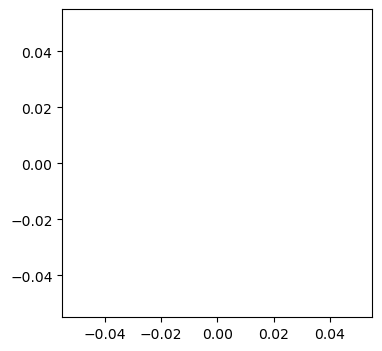

In [113]:
def plot_all_swarm(
    neu_data : pd.DataFrame,
    metric : str,
    data,
    null_dist
):
    data = F.average_sample_data(data)
    null_dist = F.average_sample_data(null_dist)
    y_min = min([min(np.array(area_data).flatten()) for area_data in data])
    y_max =  max([max(np.array(area_data).flatten()) for area_data in data])
    cell_area_groups = F.define_cell_area_groups(neu_data)
    for i, area_name in enumerate(cell_area_groups.keys()):
        construct_swarm_for_area(
            title=f"{area_name}",
            metric=metric,
            data=[data[0][i], data[1][i]],
            null_dist=[null_dist[0][i], null_dist[1][i]],
            y_min=y_min-0.02,
            y_max=y_max+0.02
        )

plot_all_swarm(neu_data, metric="ps", data=ps_, null_dist=ps_boot)

In [114]:
ps_

[[[], [], [], [], [], []], [[], [], [], [], [], []]]